# Purpose

### 2022-02-03
In this notebook I'll upload the cluster labels for the current best model to bigQuery.

To recap coverage:
- 49k subreddits (up from 19k)

---

The best model logged in mlfow has this UUID:<br>
`e37b0a2c3af54c588818e7efdde15df5`


We need to increase the clusters labels on both ends (fewer than 52 and more than 400) because there are cases where
- at 52 we sometimes still have orphan subreddits for country to country clusters (DE to DE and FR to FR)
- at 400 we have clusters with 50+ subreddits

# Imports & notebook setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Regular Imports
import os
from datetime import datetime

from google.cloud import bigquery

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib_venn import venn2_unweighted, venn3_unweighted


os.environ['GOOGLE_CLOUD_PROJECT'] = 'data-prod-165221'

In [3]:
# subclu imports

from subclu.utils.hydra_config_loader import LoadHydraConfig
from subclu.data.data_loaders import LoadPosts, LoadSubreddits
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)
from subclu.utils.data_irl_style import get_colormap
from subclu.models.clustering_utils import fancy_dendrogram


setup_logging()
print_lib_versions([pd, np])

python		v 3.7.11
===
pandas		v: 1.2.4
numpy		v: 1.19.5


# Load model labels

Ideally we could just pull the configuration data from github, but for now I'm just manually copying the artifact locations


In [4]:
# config_clust_v040 = LoadHydraConfig(
#     config_name='v0.4.0_2021_10_14-use_multi_lower_case_false_00',
#     config_path="../config/data_embeddings_to_cluster",
# )

In [11]:
run_uuid = 'e37b0a2c3af54c588818e7efdde15df5'
run_artifacts_uri = (
    f'gs://i18n-subreddit-clustering/mlflow/mlruns/25/{run_uuid}/artifacts'
)

gs_optimal_ks = f"{run_artifacts_uri}/optimal_ks/optimal_ks.parquet"
gs_model_labels = f"{run_artifacts_uri}/df_labels/df_labels.parquet"

In [12]:
# !gsutil ls $run_artifacts_uri

## optimal values for K (cluster number)

In [13]:
# !pip install gcsfs

In [14]:
%%time
df_opt_ks = pd.read_parquet(gs_optimal_ks)
print(df_opt_ks.shape)

(22, 2)
CPU times: user 24.5 ms, sys: 3.74 ms, total: 28.3 ms
Wall time: 793 ms


## Labels for multiple values of k

We'll use the optimal values to filter out & keep only the labels we's use for One Feed.


Replace `predicted` to `majority` to show that the model is simply picking the majority lable, not really predicting it.

Rename column: `model_leaves_list_order_left_to_right` so that it's easier for people to understand and use. Maybe `model_distance_order`?

rename columns so that they don't start with a number, otherwise we'll get this bigQuery error:
```bash
GenericGBQException: Reason: 
    400 POST https://bigquery.googleapis.com/bigquery/v2/projects/reddit-employee-datasets/datasets/david_bermejo/tables: 

    Invalid field name "052_k_label". 
    Fields must contain only letters, numbers, and underscores, start with a letter or underscore, and be at most 300 characters long.
```

In [25]:
%%time
col_new_model_order = 'model_sort_order'
col_primary_topic_rename = 'primary_topic_1214'

df_labels_full = pd.read_parquet(gs_model_labels)

# Rename to standardize
df_labels_full = (
    df_labels_full
    # Rename predicted to majority
    .rename(columns={c: c.replace('-predicted-', '_majority_') for c in df_labels_full.columns})
    # label makes more sense than labels
    .rename(columns={c: c.replace('_k_labels', '_k_label') for c in df_labels_full.columns if c.endswith('_k_labels')})
    .rename(columns={
        'model_leaves_list_order_left_to_right': col_new_model_order,
        'primary_topic': col_primary_topic_rename,
        })
    .sort_values(by=[col_new_model_order], ascending=True)
)

# convert labels to proper dtype (integer)
l_cols_label_all = [c for c in df_labels_full.columns if c.endswith('_label')]
df_labels_full[l_cols_label_all] = df_labels_full[l_cols_label_all].astype(int)
del l_cols_label_all

df_labels_full['posts_for_modeling_count'] = df_labels_full['posts_for_modeling_count'].fillna(0).astype(int)

print(df_labels_full.shape)

(49558, 119)
CPU times: user 514 ms, sys: 97.8 ms, total: 612 ms
Wall time: 1.42 s


In [26]:
df_labels_full.iloc[:10, :20]

,model_sort_order,subreddit_name,subreddit_id,primary_topic_1214,posts_for_modeling_count,k_0010_label,k_0013_label,k_0020_label,k_0023_label,k_0030_label,k_0040_label,k_0041_label,k_0050_label,k_0059_label,k_0060_label,k_0063_label,k_0070_label,k_0079_label,k_0080_label,k_0085_label
36697,0,realdesigirls,t5_qd3sd,Beauty and Makeup,10,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
634,1,actresszone,t5_4o5kdd,None,213,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2912,2,armpitworshippers,t5_4v2qim,Celebrity,17,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
21008,3,hotdesiceleb,t5_5bm47h,None,56,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7352,4,byootiphul,t5_4y3z97,None,100,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
12285,5,desilove,t5_4ulcg7,None,144,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
21048,6,hotmodelsnbabes,t5_hn9kj,Mature Themes and Adult Content,39,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
21083,7,hottamilcelebs,t5_3zsf3i,Celebrity,151,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6277,8,bollywoodhotactress,t5_4e2t8g,None,90,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
22114,9,indianrodraiser,t5_53rabj,None,147,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [27]:
df_labels_full.iloc[:10, -20:]

,k_1750_majority_primary_topic,k_1840_majority_primary_topic,k_2000_majority_primary_topic,k_2207_majority_primary_topic,k_2250_majority_primary_topic,k_2351_majority_primary_topic,k_2500_majority_primary_topic,k_2750_majority_primary_topic,k_2830_majority_primary_topic,k_3000_majority_primary_topic,k_3145_majority_primary_topic,k_3200_majority_primary_topic,k_3400_majority_primary_topic,k_3411_majority_primary_topic,k_3600_majority_primary_topic,k_3706_majority_primary_topic,k_3800_majority_primary_topic,k_3864_majority_primary_topic,k_3927_majority_primary_topic,k_4000_majority_primary_topic
36697,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
634,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
2912,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
21008,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
7352,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
12285,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature 

### Filter to only k-optimal columns

Makes it easy to remove noise & understand cut-offs better.

We need to rename the values in `col_prefix` because I ended up adding an underscore between k and the number...

In [45]:
df_opt_ks['col_prefix_clean'] = df_opt_ks['col_prefix'].str.replace('k', 'k_')
df_opt_ks.head()

,k,col_prefix,col_prefix_clean
0010_to_0020,13,k0013,k_0013
0020_to_0040,23,k0023,k_0023
0040_to_0050,41,k0041,k_0041
0050_to_0060,59,k0059,k_0059
0060_to_0070,63,k0063,k_0063


In [46]:
# df_labels_full.head()

In [48]:
l_cols_label_core = [
    col_new_model_order,
    'posts_for_modeling_count',
    'subreddit_id',
    'subreddit_name',
    col_primary_topic_rename,
]

cols_top_k = [c for c in df_labels_full.columns 
              if any(c.startswith(k_) for k_ in df_opt_ks[df_opt_ks['k'] >= 10]['col_prefix_clean'].unique())
              ]

df_labels = (
    df_labels_full[l_cols_label_core + cols_top_k]
    .sort_values(by=[col_new_model_order], ascending=True)
).copy()


# move "k" to front so that we don't get bigQuery errors
df_labels = (
    df_labels
    .rename(columns={c: f"k{c.replace('_k_', '_')}" for c in df_labels.columns if '_k_' in c})
)

counts_describe(df_labels)

,dtype,count,unique,unique-percent,null-count,null-percent
model_sort_order,int64,"49,558","49,558",100.00%,0,0.00%
posts_for_modeling_count,int64,"49,558",999,2.02%,0,0.00%
subreddit_id,object,"49,558","49,558",100.00%,0,0.00%
subreddit_name,object,"49,558","49,558",100.00%,0,0.00%
primary_topic_1214,object,"39,412",52,0.13%,"10,146",20.47%
k_0013_label,int64,"49,558",13,0.03%,0,0.00%
k_0023_label,int64,"49,558",23,0.05%,0,0.00%
k_0041_label,int64,"49,558",41,0.08%,0,0.00%
k_0059_label,int64,"49,558",59,0.12%,0,0.00%
k_0063_label,int64,"49,558",63,0.13%,0,0.00%


# Check overall primary topic & clusters before uploading

Just a simple visual check before uploading.

In [49]:
value_counts_and_pcts(df_labels, col_primary_topic_rename, top_n=10)

,primary_topic_1214-count,primary_topic_1214-percent,primary_topic_1214-pct_cumulative_sum
Mature Themes and Adult Content,"10,412",21.0%,21.0%
nan,"10,146",20.5%,41.5%
Gaming,"4,040",8.2%,49.6%
Technology,"1,603",3.2%,52.9%
Music,"1,474",3.0%,55.8%
Place,"1,344",2.7%,58.6%
Internet Culture and Memes,"1,264",2.6%,61.1%
Celebrity,"1,077",2.2%,63.3%
Funny/Humor,950,1.9%,65.2%
"Business, Economics, and Finance",918,1.9%,67.0%


### Check a few subs next to each other

If we sort by `model_distance_order` we should see the most similar subs next to each other as ranked by the hierarchical cluster model (`AgglomerativeCluster`).

:lol-cry: `christianmusic` gets grouped next to metal subs...

In [50]:
df_labels.head(20)

,model_sort_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_1214,k_0013_label,k_0023_label,k_0041_label,k_0059_label,k_0063_label,...,k_1560_majority_primary_topic,k_1840_majority_primary_topic,k_2207_majority_primary_topic,k_2351_majority_primary_topic,k_2830_majority_primary_topic,k_3145_majority_primary_topic,k_3411_majority_primary_topic,k_3706_majority_primary_topic,k_3864_majority_primary_topic,k_3927_majority_primary_topic
36697,0,10,t5_qd3sd,realdesigirls,Beauty and Makeup,1,1,1,1,1,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
634,1,213,t5_4o5kdd,actresszone,None,1,1,1,1,1,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
2912,2,17,t5_4v2qim,armpitworshippers,Celebrity,1,1,1,1,1,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
21008,3,56,t5_5bm47h,hotdesiceleb,None,1,1,1,1,1,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
7352,4,100,t5_4y3z97,byootiphul,None,1,1,1,1,1,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
12285,5,144,t5_4ulcg7,desilove,None,1,1,1,1,1,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
21048,6,39,t5_hn9kj,hotmodelsnbabes,Mature Themes and Adult Content,1,1,1,1,1,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
21083,7,151,t5_3zsf3i,hottamilcelebs,Celebrity,1,1,1,1,1,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
6277,8,90,t5_4e2t8g,bollywoodhotactress,None,1,1,1,1,1,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
22114,9,147,t5_53rabj,indianrodraiser,None,1,1,1,1,1,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Matur

In [51]:
df_labels.iloc[900:915, :]

,model_sort_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_1214,k_0013_label,k_0023_label,k_0041_label,k_0059_label,k_0063_label,...,k_1560_majority_primary_topic,k_1840_majority_primary_topic,k_2207_majority_primary_topic,k_2351_majority_primary_topic,k_2830_majority_primary_topic,k_3145_majority_primary_topic,k_3411_majority_primary_topic,k_3706_majority_primary_topic,k_3864_majority_primary_topic,k_3927_majority_primary_topic
44420,900,355,t5_2s8p2y,tiktok_tits,Mature Themes and Adult Content,1,1,2,2,2,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
23150,901,40,t5_scuo2,jazzy_guns,Mature Themes and Adult Content,1,1,2,2,2,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
2802,902,129,t5_3cv21,arianagrandeass,Mature Themes and Adult Content,1,1,2,2,2,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
22561,903,73,t5_2jgrf2,iokalissafans,Mature Themes and Adult Content,1,1,2,2,2,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
27129,904,67,t5_2bvbfd,malenicruz,None,1,1,2,2,2,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
38267,905,23,t5_4zeiwm,sammyy02kfans,None,1,1,2,2,2,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
25061,906,89,t5_p9961,larsapippen,Mature Themes and Adult Content,1,1,2,2,2,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
9178,907,53,t5_3orl2,cj_miles,Mature Themes and Adult Content,1,1,2,2,2,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
9179,908,267,t5_5cdqc8,cjthedon103,None,1,1,2,2,2,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
23527,909,24,t

In [52]:
df_labels.iloc[10000:10015, :]

,model_sort_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_1214,k_0013_label,k_0023_label,k_0041_label,k_0059_label,k_0063_label,...,k_1560_majority_primary_topic,k_1840_majority_primary_topic,k_2207_majority_primary_topic,k_2351_majority_primary_topic,k_2830_majority_primary_topic,k_3145_majority_primary_topic,k_3411_majority_primary_topic,k_3706_majority_primary_topic,k_3864_majority_primary_topic,k_3927_majority_primary_topic
6490,10000,530,t5_2kmmiu,bornforboobs,Mature Themes and Adult Content,3,5,10,12,12,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
49351,10001,536,t5_2mqhch,yummyboobs,Mature Themes and Adult Content,3,5,10,12,12,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
6387,10002,558,t5_2gxrl3,boobstitsclub,Mature Themes and Adult Content,3,5,10,12,12,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
6377,10003,484,t5_3mu4l0,boobsglory,Mature Themes and Adult Content,3,5,10,12,12,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
19106,10004,514,t5_3pd4rh,gotboobs,Mature Themes and Adult Content,3,5,10,12,12,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
6388,10005,544,t5_3ifrjo,boobsuniverse,Mature Themes and Adult Content,3,5,10,12,12,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
6389,10006,518,t5_2pumx6,boobsworld,Mature Themes and Adult Content,3,5,10,12,12,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
5384,10007,547,t5_3co5sh,bigboobsmenu,Mature Themes and Adult Content,3,5,10,12,12,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
6374,10008,542,t5_3vui59,boobseclipse,Mature Themes and Adult Content,3,5,10,12,12,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Theme

In [53]:
df_labels.iloc[22000:22015, :]

,model_sort_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_1214,k_0013_label,k_0023_label,k_0041_label,k_0059_label,k_0063_label,...,k_1560_majority_primary_topic,k_1840_majority_primary_topic,k_2207_majority_primary_topic,k_2351_majority_primary_topic,k_2830_majority_primary_topic,k_3145_majority_primary_topic,k_3411_majority_primary_topic,k_3706_majority_primary_topic,k_3864_majority_primary_topic,k_3927_majority_primary_topic
41798,22000,1000,t5_2tgkm,sticknpokes,Hobbies,6,10,18,25,25,...,Art,Art,Art,Art,Art,Art,Art,Art,Art,Art
45007,22001,212,t5_34ask,traditionalflash,Art,6,10,18,25,25,...,Art,Art,Art,Art,Art,Art,Art,Art,Art,Art
42966,22002,106,t5_2wcor,tattoocoverups,Art,6,10,18,25,25,...,Art,Art,Art,Art,Art,Art,Art,Art,Art,Art
42963,22003,308,t5_2tmyg,tattooadvice,Art,6,10,18,25,25,...,Art,Art,Art,Art,Art,Art,Art,Art,Art,Art
42977,22004,739,t5_2vao1,tattooremoval,None,6,10,18,25,25,...,Art,Art,Art,Art,Art,Art,Art,Art,Art,Art
13341,22005,446,t5_2vjjq,drawmytattoo,Art,6,10,18,25,25,...,Art,Art,Art,Art,Art,Art,Art,Art,Art,Art
42964,22006,448,t5_pzl64,tattooapprentice,Art,6,10,18,25,25,...,Art,Art,Art,Art,Art,Art,Art,Art,Art,Art
42976,22007,62,t5_2sdu5,tattooing,Art,6,10,18,25,25,...,Art,Art,Art,Art,Art,Art,Art,Art,Art,Art
42965,22008,268,t5_2wt0t,tattooartists,Art,6,10,18,25,25,...,Art,Art,Art,Art,Art,Art,Art,Art,Art,Art
42967,22009,1000,t5_2t57f,tattoodesigns,Art,6,10,18,25,25,...,Art,Art,Art,Art,Art,Art,Art,Art,Art,Art


In [55]:
df_labels.iloc[25000:25015, :]

,model_sort_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_1214,k_0013_label,k_0023_label,k_0041_label,k_0059_label,k_0063_label,...,k_1560_majority_primary_topic,k_1840_majority_primary_topic,k_2207_majority_primary_topic,k_2351_majority_primary_topic,k_2830_majority_primary_topic,k_3145_majority_primary_topic,k_3411_majority_primary_topic,k_3706_majority_primary_topic,k_3864_majority_primary_topic,k_3927_majority_primary_topic
23550,25000,587,t5_2qhym,journalism,Careers,7,12,21,28,30,...,Activism,Activism,Learning and Education,Learning and Education,Learning and Education,Careers,Careers,Careers,Careers,Careers
27905,25001,13,t5_2r5m5,mediation,None,7,12,21,28,30,...,Activism,Activism,Learning and Education,Learning and Education,Learning and Education,Careers,Careers,Careers,Careers,Careers
19133,25002,19,t5_q3lut,gotterfunken,Activism,7,12,21,28,30,...,Activism,Activism,Learning and Education,Learning and Education,Learning and Education,Careers,Careers,Careers,Careers,Careers
29734,25003,139,t5_2saa5,mun,Politics,7,12,21,28,30,...,Activism,Activism,Learning and Education,Learning and Education,Learning and Education,Careers,Careers,Careers,Careers,Careers
654,25004,80,t5_42yc17,actuary_news,Careers,7,12,21,28,30,...,Activism,Activism,Learning and Education,Learning and Education,Learning and Education,Careers,Careers,Careers,Careers,Careers
10947,25005,6,t5_5ggn84,cultslighthouseintlgp,None,7,12,21,28,30,...,Activism,Activism,Learning and Education,Learning and Education,Learning and Education,Careers,Careers,Careers,Careers,Careers
34923,25006,1000,t5_2xy00,policeuk,Law,7,12,21,28,30,...,Law,Law,Careers,Careers,Careers,Careers,Careers,Careers,Careers,Careers
34915,25007,758,t5_2qhxd,police,Law,7,12,21,28,30,...,Law,Law,Careers,Careers,Careers,Careers,Careers,Careers,Careers,Careers
3280,25008,72,t5_33cpo,askle,Learning and Education,7,12,21,28,30,...,Law,Law,Careers,Careers,Careers,Careers,Careers,Careers,Careers,Careers
3282,25009,176,t5_2yogd,askleo,Law,7,12,21,28,30,...,Law,Law,Careers,Careers,Careers,Careers,Careers,Careers,Careers,Careers


In [54]:
df_labels.iloc[32000:32015, :]

,model_sort_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_1214,k_0013_label,k_0023_label,k_0041_label,k_0059_label,k_0063_label,...,k_1560_majority_primary_topic,k_1840_majority_primary_topic,k_2207_majority_primary_topic,k_2351_majority_primary_topic,k_2830_majority_primary_topic,k_3145_majority_primary_topic,k_3411_majority_primary_topic,k_3706_majority_primary_topic,k_3864_majority_primary_topic,k_3927_majority_primary_topic
21182,32000,1000,t5_54l7tn,howtoopenbinanceacc,Crypto,9,15,28,38,40,...,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto
37034,32001,1000,t5_5b73dy,referencecodebinance,None,9,15,28,38,40,...,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto
5587,32002,1000,t5_5b7xp7,binancebonuscodes,Crypto,9,15,28,38,40,...,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto
5592,32003,1000,t5_594ses,binancesgreferral,Crypto,9,15,28,38,40,...,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto
10762,32004,1000,t5_5fh4ce,cryptoplane,None,9,15,28,38,40,...,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto
10674,32005,1000,t5_5f0syj,cryptocaisson,None,9,15,28,38,40,...,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto
10702,32006,1000,t5_59pr9o,cryptofarmer,Crypto,9,15,28,38,40,...,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto,Crypto
37328,32007,469,t5_25k400,reviewsoffers,None,9,15,28,38,40,...,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals
37047,32008,1000,t5_46liop,referralwallet,Marketplace and Deals,9,15,28,38,40,...,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals
39926,32009,1000,t5_2zvhi,signupbonuses,Marketplace and Deals,9,15,28,38,40,...,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals,Marketplace and Deals


In [56]:
df_labels.iloc[35000:35015, :]

,model_sort_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_1214,k_0013_label,k_0023_label,k_0041_label,k_0059_label,k_0063_label,...,k_1560_majority_primary_topic,k_1840_majority_primary_topic,k_2207_majority_primary_topic,k_2351_majority_primary_topic,k_2830_majority_primary_topic,k_3145_majority_primary_topic,k_3411_majority_primary_topic,k_3706_majority_primary_topic,k_3864_majority_primary_topic,k_3927_majority_primary_topic
8380,35000,13,t5_3f6os,celticunion,Politics,10,17,31,41,44,...,History,History,History,Place,Place,Place,Place,Place,Place,Place
22669,35001,282,t5_2tlyg,irishhistory,History,10,17,31,41,44,...,History,History,History,Place,Place,Place,Place,Place,Place,Place
8377,35002,77,t5_2qqlv,celtic,"Culture, Race, and Ethnicity",10,17,31,41,44,...,History,History,History,Place,Place,Place,Place,Place,Place,Place
38721,35003,21,t5_2tahb,scottish,Place,10,17,31,41,44,...,History,History,History,Place,Place,Place,Place,Place,Place,Place
33327,35004,8,t5_4ncoo2,paganachd,None,10,17,31,41,44,...,History,History,History,Place,Place,Place,Place,Place,Place,Place
38720,35005,8,t5_2slgu,scots,None,10,17,31,41,44,...,History,History,History,Place,Place,Place,Place,Place,Place,Place
31313,35006,248,t5_2scl4,norse,"Reading, Writing, and Literature",10,17,31,41,44,...,History,History,History,History,History,History,History,"Culture, Race, and Ethnicity","Culture, Race, and Ethnicity","Culture, Race, and Ethnicity"
31314,35007,116,t5_34380,norsemythology,"Culture, Race, and Ethnicity",10,17,31,41,44,...,History,History,History,History,History,History,History,"Culture, Race, and Ethnicity","Culture, Race, and Ethnicity","Culture, Race, and Ethnicity"
47038,35008,112,t5_2qock,viking,"Culture, Race, and Ethnicity",10,17,31,41,44,...,History,History,History,History,History,History,History,"Culture, Race, and Ethnicity","Culture, Race, and Ethnicity","Culture, Race, and Ethnicity"
47040,35009,108,t5_57qsvt,vikingnorse,History,10,17,31,41,44,...,History,History,History,History,History,History,History,"Culture, Race, and Ethnicity","Culture, Race, and Ethnicity","Culture, Race, and Ethnicity"


In [57]:
df_labels.iloc[41000:41015, :]

,model_sort_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_1214,k_0013_label,k_0023_label,k_0041_label,k_0059_label,k_0063_label,...,k_1560_majority_primary_topic,k_1840_majority_primary_topic,k_2207_majority_primary_topic,k_2351_majority_primary_topic,k_2830_majority_primary_topic,k_3145_majority_primary_topic,k_3411_majority_primary_topic,k_3706_majority_primary_topic,k_3864_majority_primary_topic,k_3927_majority_primary_topic
26356,41000,355,t5_2z26a,lordhuron,Music,12,19,34,50,53,...,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music
43645,41001,130,t5_2st9u,thedearhunter,Music,12,19,34,50,53,...,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music
43863,41002,323,t5_2rr5z,themountaingoats,Music,12,19,34,50,53,...,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music
18878,41003,514,t5_2tis5,gojira,Music,12,19,34,50,53,...,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music
35494,41004,229,t5_2smet,primus,Music,12,19,34,50,53,...,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music
29140,41005,472,t5_2rj5f,modestmouse,Music,12,19,34,50,53,...,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music
42837,41006,1000,t5_2t1l9,tameimpala,Music,12,19,34,50,53,...,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music
933,41007,90,t5_2t9fk,afireinside,Music,12,19,34,50,53,...,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music
41268,41008,100,t5_2xz32,spiritbox,Music,12,19,34,50,53,...,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music
29916,41009,103,t5_2t0px,mybloodyvalentine,Music,12,19,34,50,53,...,Music,Music,Music,Music,Music,Music,Music,Music,Music,Music


In [58]:
df_labels.iloc[43000:43015, :]

,model_sort_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_1214,k_0013_label,k_0023_label,k_0041_label,k_0059_label,k_0063_label,...,k_1560_majority_primary_topic,k_1840_majority_primary_topic,k_2207_majority_primary_topic,k_2351_majority_primary_topic,k_2830_majority_primary_topic,k_3145_majority_primary_topic,k_3411_majority_primary_topic,k_3706_majority_primary_topic,k_3864_majority_primary_topic,k_3927_majority_primary_topic
11522,43000,862,t5_mljgb,dannygonzalez,Podcasts and Streamers,12,20,35,52,55,...,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers
11520,43001,134,t5_rbrk5,danny_duncan,None,12,20,35,52,55,...,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers
11523,43002,1000,t5_znl4x,dannymullen,Podcasts and Streamers,12,20,35,52,55,...,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers
41768,43003,45,t5_3c5mj,steve1989mreinfo,None,12,20,35,52,55,...,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes
41780,43004,38,t5_2fduyl,stevewallis,Travel,12,20,35,52,55,...,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes
24778,43005,9,t5_44nix0,kurtcaz,None,12,20,35,52,55,...,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes
40331,43006,3,t5_3hwz4,slavesuk,Music,12,20,35,52,55,...,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes
46183,43007,8,t5_3f3wi,unexpectedyogscast,None,12,20,35,52,55,...,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes
23434,43008,113,t5_3eupv,jockopodcast,Podcasts and Streamers,12,20,35,52,55,...,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes
49392,43009,69,t5_4tarqb,zacktelander,Sports,12,20,35,52,55,...,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Podcasts and Streamers,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes,Internet Culture and Memes


In [59]:
df_labels.tail(15)

,model_sort_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_1214,k_0013_label,k_0023_label,k_0041_label,k_0059_label,k_0063_label,...,k_1560_majority_primary_topic,k_1840_majority_primary_topic,k_2207_majority_primary_topic,k_2351_majority_primary_topic,k_2830_majority_primary_topic,k_3145_majority_primary_topic,k_3411_majority_primary_topic,k_3706_majority_primary_topic,k_3864_majority_primary_topic,k_3927_majority_primary_topic
3669,49543,246,t5_3yszx8,audiosgonewild,Mature Themes and Adult Content,13,23,41,59,63,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
18947,49544,495,t5_3ig11,gonewildaudible,Mature Themes and Adult Content,13,23,41,59,63,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
18948,49545,1000,t5_2u463,gonewildaudio,"Reading, Writing, and Literature",13,23,41,59,63,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
3700,49546,74,t5_3lpwtl,auralescentbaddies,Mature Themes and Adult Content,13,23,41,59,63,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
48965,49547,320,t5_2yydcx,yagami_yato,Mature Themes and Adult Content,13,23,41,59,63,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
48966,49548,1000,t5_2cy2mq,yagamiyato,Mature Themes and Adult Content,13,23,41,59,63,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
33221,49549,135,t5_33209,overheardsex,Mature Themes and Adult Content,13,23,41,59,63,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
20417,49550,40,t5_35k9d,hfo,Mature Themes and Adult Content,13,23,41,59,63,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
39570,49551,94,t5_3efn1,shibbysays,Mature Themes and Adult Content,13,23,41,59,63,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and 

# Upload to BigQuery

In [60]:
df_labels.shape

(49558, 49)

In [67]:
df_labels.head()

,model_sort_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_1214,k_0013_label,k_0023_label,k_0041_label,k_0059_label,k_0063_label,...,k_1560_majority_primary_topic,k_1840_majority_primary_topic,k_2207_majority_primary_topic,k_2351_majority_primary_topic,k_2830_majority_primary_topic,k_3145_majority_primary_topic,k_3411_majority_primary_topic,k_3706_majority_primary_topic,k_3864_majority_primary_topic,k_3927_majority_primary_topic
36697,0,10,t5_qd3sd,realdesigirls,Beauty and Makeup,1,1,1,1,1,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
634,1,213,t5_4o5kdd,actresszone,None,1,1,1,1,1,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
2912,2,17,t5_4v2qim,armpitworshippers,Celebrity,1,1,1,1,1,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
21008,3,56,t5_5bm47h,hotdesiceleb,None,1,1,1,1,1,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content
7352,4,100,t5_4y3z97,byootiphul,None,1,1,1,1,1,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content


In [61]:
run_uuid

'e37b0a2c3af54c588818e7efdde15df5'

In [65]:
# !pip install pandas-gbq

In [ ]:
    .assign(table_creation_date=datetime.utcnow().date())

In [70]:
%%time

from datetime import datetime

(
    df_labels
    .assign(table_creation_date=datetime.utcnow())
    .assign(mlflow_run_uuid=run_uuid)
    .to_gbq(
        destination_table='david_bermejo.subclu_v0041_subreddit_clusters_c_a',
        project_id='reddit-employee-datasets',
        chunksize=1000,
        if_exists='replace',
    )
)

49558 out of 49558 rows loaded."                                                                                         | 0/1 [00:00<?, ?it/s]14:37:09 | INFO | "
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1145.36it/s]

CPU times: user 283 ms, sys: 30.6 ms, total: 313 ms
Wall time: 7.12 s


# Check specific subreddits (for fun)

hi team, quick update before the weekend: new table for clusters is now on bigQuery

`reddit-employee-datasets:david_bermejo.subclu_v0040_subreddit_clusters_c_a`

if you sort by `model_distance_order` you will get subreddits sorted by how close the model found them — so the subreddit right before and right after are the closest ones to the subreddit in the middle.

Next week Jennie and I will be working on how to reshape the data for QA, but here's a quick peek:

Finance cluster looks good:
We can see finance-related subreddits from multiple countries next to each other:
- `mexicofinanciero` -> Spanish, Mexico
- `beleggen` -> Dutch, Netherlands
- `finanzen` -> Germany
- `literaciafinanceira`, `investimentos`, -> Portuguese, Portugal
- `vosfinances` -> French, France
- `italiapersonalfinance` -> Italian, Italy
- `phinvest` -> English, Phillipines
- `malaysianpf` -> English, Malaysia


Clusters around France & Paris look decent.

In [71]:
l_subs_to_qa = [
    # 'christianmusic',
    # 'dune',
    # 'fussball',
    # 'de',
    'vosfinances',
    'france',
    # 'frenchrap',
    'mangafr',
    'paris',
]
n_subs_nearby = 4
for sub_name in l_subs_to_qa:
    sub_rank = df_labels.loc[df_labels['subreddit_name'] == sub_name, col_new_model_order].values[0]

    display(
        style_df_numeric(
            df_labels
            [df_labels[col_new_model_order].between(sub_rank - n_subs_nearby, sub_rank + n_subs_nearby, inclusive='both')]
            # .drop(['posts_for_modeling_count'], axis=1)
            ,
            l_bar_simple=[c for c in df_labels.columns if 'label' in c]
        )
    )

,model_sort_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_1214,k_0013_label,k_0023_label,k_0041_label,k_0059_label,k_0063_label,k_0079_label,k_0085_label,k_0118_label,k_0320_label,k_0657_label,k_0958_label,k_1065_label,k_1560_label,k_1840_label,k_2207_label,k_2351_label,k_2830_label,k_3145_label,k_3411_label,k_3706_label,k_3864_label,k_3927_label,k_0013_majority_primary_topic,k_0023_majority_primary_topic,k_0041_majority_primary_topic,k_0059_majority_primary_topic,k_0063_majority_primary_topic,k_0079_majority_primary_topic,k_0085_majority_primary_topic,k_0118_majority_primary_topic,k_0320_majority_primary_topic,k_0657_majority_primary_topic,k_0958_majority_primary_topic,k_1065_majority_primary_topic,k_1560_majority_primary_topic,k_1840_majority_primary_topic,k_2207_majority_primary_topic,k_2351_majority_primary_topic,k_2830_majority_primary_topic,k_3145_majority_primary_topic,k_3411_majority_primary_topic,k_3706_majority_primary_topic,k_3864_majority_primary_topic,k_3927_majority_primary_topic
13617,"24,752",86,t5_39rbe,dutchfire,"Business, Economics, and Finance",7,12,21,28,30,39,40,52,147,292,429,481,697,825,994,"1,059","1,273","1,418","1,526","1,662","1,738","1,763",Place,Learning and Education,"Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance"
18144,"24,753",101,t5_3jbvy,geldzaken,None,7,12,21,28,30,39,40,52,147,292,429,481,697,825,994,"1,059","1,273","1,418","1,526","1,662","1,738","1,763",Place,Learning and Education,"Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance"
36168,"24,754",55,t5_5en24n,quebecfinance,None,7,12,21,28,30,39,40,52,147,292,429,481,697,825,994,"1,059","1,273","1,418","1,526","1,662","1,738","1,763",Place,Learning and Education,"Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance"
16048,"24,755","1,000",t5_35m5e,finanzen,"Business, Economics, and Finance",7,12,21,28,30,39,40,52,147,292,429,481,697,825,994,"1,059","1,273","1,418","1,526","1,662","1,738","1,763",Place,Learning and Education,"Business, Economics, and Finance","Business, Economics, and Finance","Business, E

,model_sort_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_1214,k_0013_label,k_0023_label,k_0041_label,k_0059_label,k_0063_label,k_0079_label,k_0085_label,k_0118_label,k_0320_label,k_0657_label,k_0958_label,k_1065_label,k_1560_label,k_1840_label,k_2207_label,k_2351_label,k_2830_label,k_3145_label,k_3411_label,k_3706_label,k_3864_label,k_3927_label,k_0013_majority_primary_topic,k_0023_majority_primary_topic,k_0041_majority_primary_topic,k_0059_majority_primary_topic,k_0063_majority_primary_topic,k_0079_majority_primary_topic,k_0085_majority_primary_topic,k_0118_majority_primary_topic,k_0320_majority_primary_topic,k_0657_majority_primary_topic,k_0958_majority_primary_topic,k_1065_majority_primary_topic,k_1560_majority_primary_topic,k_1840_majority_primary_topic,k_2207_majority_primary_topic,k_2351_majority_primary_topic,k_2830_majority_primary_topic,k_3145_majority_primary_topic,k_3411_majority_primary_topic,k_3706_majority_primary_topic,k_3864_majority_primary_topic,k_3927_majority_primary_topic
16844,"34,023",79,t5_2rj8v,francais,None,10,17,30,40,43,54,57,81,226,449,648,725,"1,051","1,236","1,484","1,580","1,888","2,096","2,264","2,456","2,562","2,597",Sports,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics
34969,"34,024",74,t5_3cwt4,politiquefrancaise,None,10,17,30,40,43,54,57,81,226,449,648,725,"1,051","1,236","1,484","1,580","1,888","2,096","2,264","2,456","2,562","2,597",Sports,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics
48973,"34,025","1,000",t5_47quxa,yahooqr,None,10,17,30,40,43,54,57,81,226,449,648,725,"1,051","1,236","1,484","1,580","1,888","2,096","2,264","2,456","2,562","2,597",Sports,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics
2446,"34,026",67,t5_2djd4u,antiracisme,"Culture, Race, and Ethnicity",10,17,30,40,43,54,57,81,226,449,648,725,"1,051","1,236","1,484","1,580","1,888","2,096","2,264","2,456","2,562","2,597",Sports,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics
16846,"34,027","1,000",t5_2qhjz,france,Place,10,17,30,40,43,54,57,81,226,449,648,725,"1,051","1,236","1,484","1,580","1,888","2,096","2,264","2,456","2,562","2,597",Sports,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics
16848,"34,028",596,t5_4c3l03,france6,None,10,17,30,40,43,54,57,81,226,449,648,725,"1,051","1,236","1,484","1,580","1,888","2,096","2,264","2,456","2,562","2,597",Sports,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics
16851,"34,029",169,t5_29145x,francedigeste,None,10,17,30,40,43,54,57,81,226,449,648,725,"1,051","1,236","1,484","1,580","1,888","2,096","2,264","2,456","2,562","2,597",Sports,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics
34753,"34,030","1,000",t5_31h78,podemos,Activism,10,17,30,40,43,54,57,81,226,449,648,725,"1,051","1,236","1,485","1,581","1,889","2,097","2,265","2,457","2,563","2,598",Sports,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics,Politics
34965,"34,031",266,t5_4achx0,politicspain,Po

,model_sort_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_1214,k_0013_label,k_0023_label,k_0041_label,k_0059_label,k_0063_label,k_0079_label,k_0085_label,k_0118_label,k_0320_label,k_0657_label,k_0958_label,k_1065_label,k_1560_label,k_1840_label,k_2207_label,k_2351_label,k_2830_label,k_3145_label,k_3411_label,k_3706_label,k_3864_label,k_3927_label,k_0013_majority_primary_topic,k_0023_majority_primary_topic,k_0041_majority_primary_topic,k_0059_majority_primary_topic,k_0063_majority_primary_topic,k_0079_majority_primary_topic,k_0085_majority_primary_topic,k_0118_majority_primary_topic,k_0320_majority_primary_topic,k_0657_majority_primary_topic,k_0958_majority_primary_topic,k_1065_majority_primary_topic,k_1560_majority_primary_topic,k_1840_majority_primary_topic,k_2207_majority_primary_topic,k_2351_majority_primary_topic,k_2830_majority_primary_topic,k_3145_majority_primary_topic,k_3411_majority_primary_topic,k_3706_majority_primary_topic,k_3864_majority_primary_topic,k_3927_majority_primary_topic
27247,"47,195",91,t5_3nrx2,mangarockapp,"Reading, Writing, and Literature",13,23,39,56,59,75,80,111,300,616,896,997,"1,460","1,729","2,076","2,212","2,666","2,956","3,209","3,482","3,630","3,691",Animals and Pets,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime
26505,"47,196",375,t5_4re3g2,lovemanga,None,13,23,39,56,59,75,80,111,300,616,896,997,"1,460","1,729","2,076","2,212","2,666","2,956","3,209","3,482","3,630","3,691",Animals and Pets,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime
27230,"47,197","1,000",t5_2ql0i,manga,"Reading, Writing, and Literature",13,23,39,56,59,75,80,111,300,616,896,997,"1,460","1,729","2,076","2,212","2,666","2,956","3,209","3,482","3,630","3,691",Animals and Pets,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime
29993,"47,198","1,000",t5_4ytkm9,myreadingmanga,Anime,13,23,39,56,59,75,80,111,300,616,896,997,"1,460","1,729","2,076","2,212","2,666","2,956","3,209","3,482","3,630","3,691",Animals and Pets,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime
27238,"47,199","1,000",t5_ne3w4,mangafr,Anime,13,23,39,56,59,75,80,111,300,616,896,997,"1,460","1,729","2,076","2,212","2,666","2,956","3,209","3,482","3,630","3,691",Animals and Pets,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime
49143,"47,200",15,t5_5b5cbn,yominotsugai,Anime,13,23,39,56,59,75,80,111,300,616,896,997,"1,460","1,729","2,076","2,212","2,666","2,956","3,209","3,482","3,630","3,691",Animals and Pets,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime
9248,"47,201",5,t5_5fae2e,classnogyaru,None,13,23,39,56,59,75,80,111,300,616,896,997,"1,460","1,729","2,076","2,212","2,666","2,956","3,209","3,482","3,630","3,691",Animals and Pets,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime
42241,"47,202",9,t5_5f1tnp,sukibare,None,13,23,39,56,59,75,80,111,300,616,896,997,"1,460","1,729","2,076","2,212","2,666","2,956","3,209","3,482","3,630","3,691",Animals and Pets,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime
39802,"47,203",302,t5_2ur20,shoujo,Anime,13,23,39,56,59,75,80,111,300,616,896,997,"1,460","1,729","2,076","2,212","2,666","2,956","3,209","3,482","3,630","3,691",Animals and Pets,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime,Anime


,model_sort_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_1214,k_0013_label,k_0023_label,k_0041_label,k_0059_label,k_0063_label,k_0079_label,k_0085_label,k_0118_label,k_0320_label,k_0657_label,k_0958_label,k_1065_label,k_1560_label,k_1840_label,k_2207_label,k_2351_label,k_2830_label,k_3145_label,k_3411_label,k_3706_label,k_3864_label,k_3927_label,k_0013_majority_primary_topic,k_0023_majority_primary_topic,k_0041_majority_primary_topic,k_0059_majority_primary_topic,k_0063_majority_primary_topic,k_0079_majority_primary_topic,k_0085_majority_primary_topic,k_0118_majority_primary_topic,k_0320_majority_primary_topic,k_0657_majority_primary_topic,k_0958_majority_primary_topic,k_1065_majority_primary_topic,k_1560_majority_primary_topic,k_1840_majority_primary_topic,k_2207_majority_primary_topic,k_2351_majority_primary_topic,k_2830_majority_primary_topic,k_3145_majority_primary_topic,k_3411_majority_primary_topic,k_3706_majority_primary_topic,k_3864_majority_primary_topic,k_3927_majority_primary_topic
6289,"22,529",94,t5_2tms9,bologna,Place,7,11,19,26,26,35,36,46,132,265,392,442,641,755,909,967,"1,170","1,300","1,400","1,527","1,594","1,619",Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place
33322,"22,530",13,t5_2w0xl,padova,None,7,11,19,26,26,35,36,46,132,265,392,442,641,755,909,967,"1,170","1,300","1,400","1,527","1,594","1,619",Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place
48443,"22,531",5,t5_5g51cq,womeninparis,None,7,11,19,26,26,35,36,46,132,265,393,443,642,756,910,968,"1,171","1,301","1,401","1,528","1,595","1,620",Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place
3252,"22,532",181,t5_2zkfk,askfrance,None,7,11,19,26,26,35,36,46,132,265,393,443,642,756,910,968,"1,171","1,301","1,401","1,528","1,595","1,620",Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place
33586,"22,533",547,t5_2qkoi,paris,Place,7,11,19,26,26,35,36,46,132,265,393,443,642,756,910,968,"1,171","1,301","1,401","1,528","1,595","1,620",Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place
33590,"22,534",92,t5_33xw1,paristravelguide,Place,7,11,19,26,26,35,36,46,132,265,393,443,642,756,910,968,"1,171","1,301","1,401","1,528","1,595","1,620",Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place
6462,"22,535",8,t5_2stgm,bordeaux,None,7,11,19,26,26,35,36,46,132,265,393,443,642,756,910,968,"1,171","1,301","1,401","1,528","1,595","1,620",Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place
30890,"22,536",15,t5_3jgid,nicefrance,None,7,11,19,26,26,35,36,46,132,265,393,443,642,756,910,968,"1,171","1,301","1,401","1,528","1,595","1,620",Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place
19317,"22,537",50,t5_2skay,grenoble,None,7,11,19,26,26,35,36,46,132,265,393,443,642,756,910,968,"1,171","1,301","1,401","1,528","1,595","1,620",Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place,Place


# Show Dendrogram at n=52

## Load linkage data

In [72]:
# !gsutil ls $run_artifacts_uri

In [73]:
path_gs_linkage = f"{run_artifacts_uri}/X_linkage"

!gsutil ls $path_gs_linkage

gs://i18n-subreddit-clustering/mlflow/mlruns/25/e37b0a2c3af54c588818e7efdde15df5/artifacts/X_linkage/X_linkage.csv
gs://i18n-subreddit-clustering/mlflow/mlruns/25/e37b0a2c3af54c588818e7efdde15df5/artifacts/X_linkage/X_linkage.parquet


In [74]:
%%time

X_linkage = pd.read_parquet(
    f"{path_gs_linkage}/X_linkage.parquet"
)
print(X_linkage.shape)

(49557, 4)
CPU times: user 55 ms, sys: 13.6 ms, total: 68.6 ms
Wall time: 853 ms


## Show dendrogram

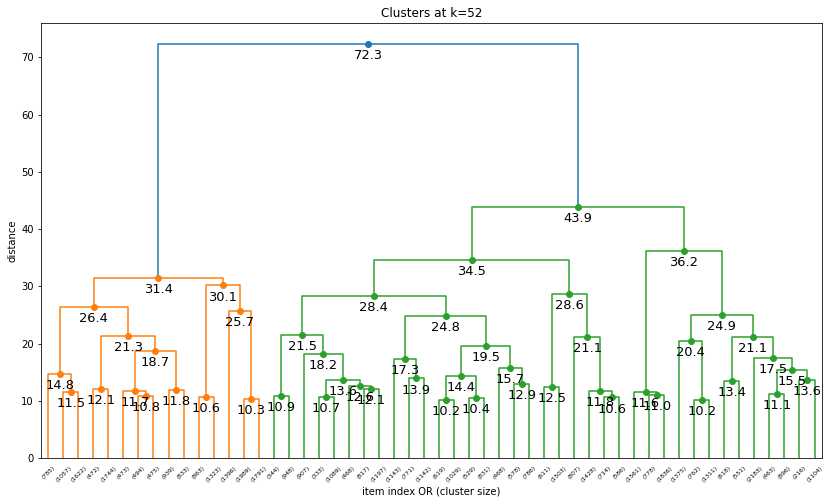

In [75]:
p_ = 52
fancy_dendrogram(
    X_linkage,
    plot_title=f"Clusters at k={p_}",
    annotate_above=X_linkage['distance'].quantile(q=0.985),
    truncate_mode='lastp',
    p=p_,
    orientation='top',
    show_leaf_counts=True, leaf_rotation=45,
    # show_contracted=False,
    # color_threshold=15.3,
)
plt.show()